# CSE620 Fall 2022 GA Mini-Project
---
Kyle Spurlock & Miku Fukuyama

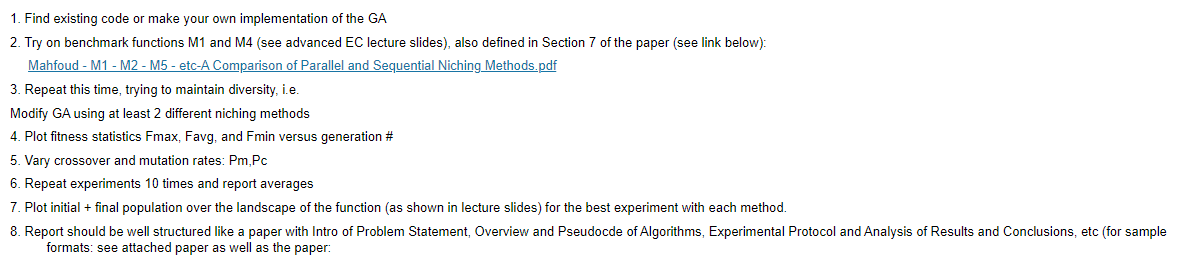

# General
---

In [61]:
!pip install bitstring
!pip install matplotlib


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [62]:
import bitstring
import struct
import numpy as np
import time
import copy
import matplotlib.pyplot as plt
import math

In [63]:
def M1(x):
  """
  Defines the M1 cost function
  """
  return np.sin(5*np.pi*x)**6

In [64]:
def M4(x):
  """
  Defines the M4 cost function
  """
  return (math.exp(-2*math.log(2)*((x-0.08)/0.854)**2))*((math.sin(5*math.pi*(x**0.75-0.05)))**6)

Plotting M1 and M4 between 0 and 1 with 2 decimal points

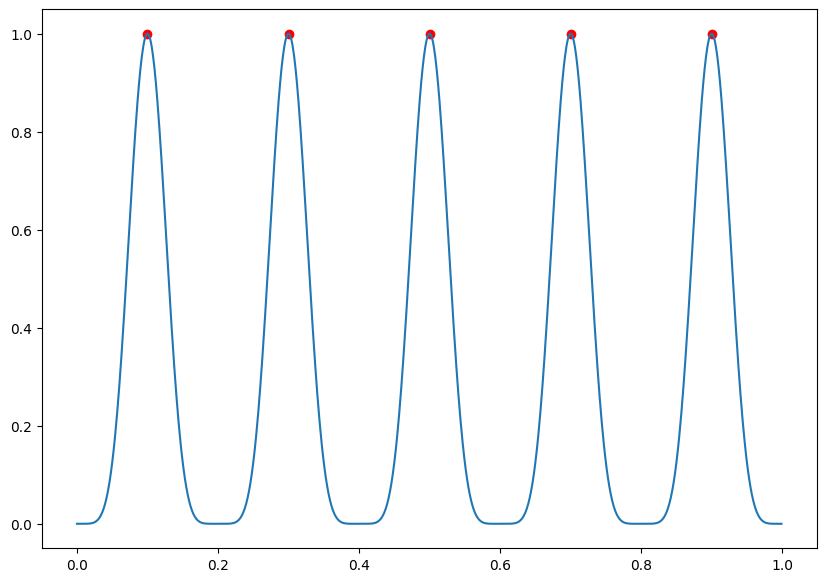

In [65]:
fig, ax = plt.subplots(figsize=(10,7))


ax.plot(
    np.arange(0, 1, 0.001), [M1(x) for x in np.arange(0, 1, 0.001)]
    )

M1_niche_points = [0.1, 0.3, 0.5, 0.7, 0.9]
ax.scatter(M1_niche_points, [M1(x) for x in M1_niche_points], color="red")

plt.show()

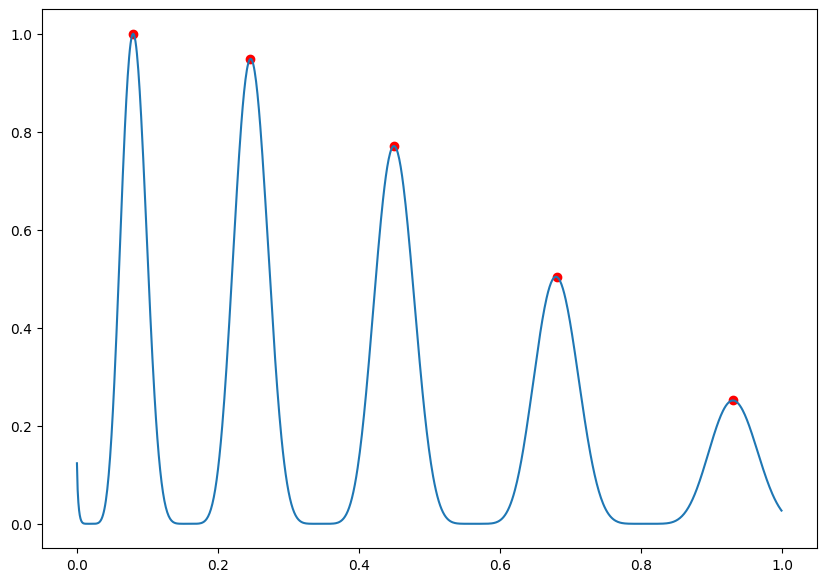

In [66]:
fig, ax = plt.subplots(figsize=(10,7))

ax.plot(
    np.arange(0, 1, 0.001), [M4(x) for x in np.arange(0, 1, 0.001)]
    )

M4_niche_points = [0.080, 0.245, 0.45, 0.68, 0.93]
ax.scatter(M4_niche_points, [M4(x) for x in M4_niche_points], color="red")
plt.show()

In [67]:
[M4(i) for i in M4_niche_points]

[0.9998668563559765,
 0.9473833831932997,
 0.7706929842711675,
 0.5039333971631196,
 0.2516075281237419]

In [68]:
%%script false --no-raise-error

"""
NOTE: UNUSED! Shown here only for comparison
"""


def float_to_bin(number):
  """
  Converts float to 32-bit binary list
  """

  return bitstring.BitArray(float=number, length=16).bin

def bin_to_float(binary_list):
  """
  Converts a list of integers (binary string) to float
  """

  # Convert integer list to string list
  f = binary_list.astype("U32")
  # Convert list to string
  f = "".join(f)

  # Convert binary string to int, specify that bit string is in base 2
  f = int(f, 2)

  # Pack f into bytes, then unpack back into float
  f = struct.unpack('f', struct.pack('I', f))[0]

  return round(math.exp(-f), 5)


Couldn't find program: 'false'


In [69]:
def constrained_bin_float(binary_list):
  """
  Since we only care about searching [0, 1], rather than encode a 32 bit float
  that has like max value 1.6 million, lets just use 10 bits (like part of the "mantissa" in a float16)
  to represent values [0, 0.99]
  """
  value = 0
  for i, v in enumerate(binary_list):
    if v == 1:
      value += 2**-(i+1)

  return value

In [70]:
test = np.array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

constrained_bin_float(test)

0.9990234375

In [71]:
def ham_dist(x, y):
  """
  Calculate the hamming distance for two binary vectors
  """
  # Alternatively: np.sum(np.abs(x - y))
  # But the below is 3x faster

  return len([1 for i, j in zip(x, y) if i != j])

ham_dist(
    [0, 1, 1, 1],
    [1, 0, 1, 1]
)

2

# Algorithm Components
---

In [72]:
test_rng = np.random.default_rng(192)

## Initialization

In [73]:
def initialize_pop(pop_size, precision=3, rand_gen=None):
  """
  Initializes the population
  """

  population = []
  for _ in range(pop_size):
    # Generate random bit strings
    population.append(
          rand_gen.integers(0, 2, size=(10,))
        )


  # Returns a matrix
  return np.array(population).astype("int")

pop = initialize_pop(30, 3, test_rng)
pop

array([[1, 1, 0, 1, 0, 0, 1, 0, 1, 1],
       [1, 1, 0, 0, 1, 1, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 1, 0, 0, 1, 0],
       [1, 0, 0, 1, 0, 1, 1, 0, 0, 1],
       [0, 0, 1, 0, 1, 1, 0, 1, 1, 1],
       [0, 1, 0, 1, 1, 0, 0, 1, 0, 1],
       [1, 0, 0, 1, 0, 0, 0, 1, 0, 0],
       [1, 1, 0, 0, 1, 1, 1, 1, 0, 0],
       [1, 0, 0, 0, 1, 0, 0, 0, 0, 1],
       [1, 1, 0, 1, 1, 1, 1, 0, 1, 0],
       [1, 0, 1, 1, 0, 0, 1, 1, 1, 0],
       [0, 0, 1, 0, 0, 1, 0, 1, 1, 0],
       [1, 1, 1, 1, 0, 1, 0, 0, 1, 0],
       [1, 0, 0, 0, 0, 1, 0, 1, 1, 0],
       [1, 1, 0, 0, 0, 0, 1, 1, 0, 1],
       [0, 0, 0, 1, 0, 1, 1, 1, 1, 0],
       [0, 1, 0, 1, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 1, 1, 1, 0, 1, 1],
       [0, 1, 0, 0, 1, 0, 0, 0, 1, 1],
       [1, 0, 0, 0, 1, 0, 0, 1, 1, 1],
       [0, 0, 1, 1, 1, 1, 0, 0, 1, 0],
       [0, 1, 1, 0, 0, 0, 1, 1, 0, 1],
       [1, 1, 0, 0, 0, 0, 0, 0, 1, 1],
       [0, 1, 0, 0, 0, 1, 1, 1, 1, 0],
       [1, 1, 1, 0, 0, 1, 1, 0, 0, 1],
       [0, 1, 1, 1, 1, 0,

## Fitness

In [74]:
def compute_fitness(batch, cost_func):
  """
  Computes fitness on a batch of solutions. Can either be just a single
  solution or multiple.
  """

  if len(batch) == 1:
    # Handles the case where we pass a single solution in the batch
    fitness = cost_func(bin_to_float(batch[0]))
  else:
    # Handles the case where we pass the population in the batch
    phenotypes = np.array([constrained_bin_float(genotype) for genotype in batch])

    fitness = np.array([cost_func(p) for p in phenotypes])
  return fitness


fitness = compute_fitness(pop, M1)
fitness

array([2.07126313e-03, 1.39563819e-08, 4.42964520e-01, 7.23056937e-05,
       1.24999885e-03, 1.41803127e-01, 1.63002959e-02, 5.94151041e-06,
       4.47524762e-01, 4.79802093e-01, 9.98983921e-01, 1.71056564e-01,
       7.43905462e-02, 7.05845301e-01, 2.86041801e-02, 9.51278120e-01,
       8.73319876e-01, 2.36615927e-01, 8.29275493e-01, 3.18341265e-01,
       2.48421894e-02, 5.02224932e-05, 9.36048151e-02, 7.23953529e-01,
       9.99745894e-01, 5.40983019e-01, 9.99887057e-01, 5.18021272e-06,
       3.18341265e-01, 6.21859217e-01])

## Operators

### Selection

In [75]:
def roulette_selection(fitness, num_mating=0, rand_gen=None):
  """
  Performs roulette selection. Only need this for the first part to compare.
  """
  selected = []
  if num_mating == 0:
    # Default value, just mate half of the population
    num_mating = len(fitness)//2

    # Need to have even number of mating
    num_mating = num_mating - (num_mating % 2)

  # Compute the distribution
  fit_dist = (fitness / fitness.sum())

  # If probabilitiy is effectively zero, set it to a very small value
  fit_dist[fit_dist == 0] = 1e-10

  # Select parent solutions (WITHOUT REPLACEMENT)
  selected = rand_gen.choice(
      len(fitness), size=(num_mating), replace=False, p=fit_dist
      )

  return selected


selected = roulette_selection(fitness, num_mating=5, rand_gen=test_rng)
selected

array([18, 23, 16, 26,  9])

In [76]:
def random_selection(fitness, num_mating=0, rand_gen=None):
  """
  Randomly select solutions with no regards to their fitness.
  For crowding, need to randomly select (basically shuffle) all solutions
  and then mate them.
  """

  if num_mating == 0:
    N = len(fitness)
  else:
    N = num_mating

  selected = rand_gen.choice(
              np.arange(len(fitness)),
              size=(N,),
              replace=False,
              )

  return selected

selected = random_selection(fitness, rand_gen=test_rng)
selected

array([26,  2, 13,  0, 24, 21, 20,  3,  8, 17, 11, 28, 16,  9, 10, 14,  6,
       27, 25,  5, 23, 18, 22, 29, 12, 15,  1,  7,  4, 19])

### Crossover

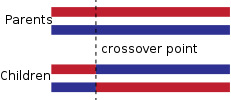

In [77]:
def one_point_cross(parent1, parent2, rand_gen=None):
  """
  Performs one point crossover
  """

  length = len(parent1)

  # Find split point (leaving sign bit alone)
  cut = rand_gen.integers(1, length-2)

  # Produce children
  child1 = np.concatenate((parent1[0:cut], parent2[cut:length]))
  child2 = np.concatenate((parent2[0:cut], parent1[cut:length]))

  assert len(child1) == len(child2) == len(parent1)

  return (child1, child2)

compute_fitness(one_point_cross(pop[0], pop[1], rand_gen=test_rng), M1)

array([5.51333464e-05, 2.89245562e-06])

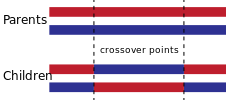

In [78]:
def two_point_cross(parent1, parent2, rand_gen=None):
  """
  Performs one point crossover
  """

  length = len(parent1)

  # Find splitting points (leaving sign bit alone)
  cut1 = rand_gen.integers(0, length-2)
  cut2 = cut1 + rand_gen.integers(1, length-cut1-1)

  # Distribute parts of parents to children
  child1 = np.concatenate(
      (parent1[0:cut1], parent2[cut1:cut2], parent1[cut2:length])
  )
  child2 = np.concatenate(
      (parent2[0:cut1], parent1[cut1:cut2], parent2[cut2:length])
  )

  return (child1, child2)

compute_fitness(two_point_cross(pop[0], pop[1], rand_gen=test_rng), M1)

array([2.07126313e-03, 1.39563819e-08])

### Mutation

In [79]:
def mutation(solution, Pm=0.003, rand_gen=None):
  """
  Just need to go through and flip bits
  """

  sol_copy = copy.deepcopy(solution)

  for i, bit in enumerate(sol_copy):
    if Pm > rand_gen.random():
      if bit == 1:
        sol_copy[i ]= 0
      else:
        sol_copy[i] = 1

  return sol_copy


for o, m in zip(pop[0], mutation(pop[0], 0.3, rand_gen=test_rng)):
  if o != m:
    print("Mutated")

Mutated
Mutated


### Reproduction

In [80]:
def reproduce(population, selected, cross_method, cost_func, Pc, Pm, rand_gen=None):
  first_parents = selected[:len(selected)//2]
  second_parents = selected[len(selected)//2:]

  replacements = {}
  child_fitness = {}

  for p1, p2 in zip(first_parents, second_parents):
    if Pc > rand_gen.random():
      # Grab the parents from the population
      parent1, parent2 = population[p1], population[p2]

      # Perform crossover
      children = cross_method(parent1, parent2, rand_gen)

      # Perform mutation
      children = [mutation(c, Pm, rand_gen) for c in children]

      # Compute child fitness
      child_fit = compute_fitness(children, cost_func)

      # Mark the population indices for replacement
      replacements[(p1, p2)] = (children[0], children[1])

      # Store the fitness of the children (easier for niching/don't need to recompute all fitness every iteration)
      child_fitness[(p1, p2)] = (child_fit[0], child_fit[1])

  return replacements, child_fitness


replacements, child_fitness = reproduce(pop, selected, two_point_cross, M1, Pc=0.95, Pm=0.003, rand_gen=test_rng)
replacements, child_fitness

({(np.int64(26), np.int64(14)): (array([0, 0, 0, 1, 1, 0, 0, 1, 1, 0]),
   array([1, 1, 0, 0, 0, 0, 1, 1, 0, 1])),
  (np.int64(2), np.int64(6)): (array([0, 1, 0, 0, 0, 1, 0, 1, 1, 0]),
   array([1, 0, 0, 1, 0, 0, 0, 0, 0, 0])),
  (np.int64(13), np.int64(27)): (array([1, 0, 0, 0, 0, 1, 0, 1, 1, 0]),
   array([1, 0, 0, 1, 0, 0, 1, 1, 1, 1])),
  (np.int64(0), np.int64(25)): (array([1, 1, 0, 1, 0, 0, 1, 0, 1, 1]),
   array([0, 1, 1, 1, 1, 0, 0, 0, 1, 1])),
  (np.int64(24), np.int64(5)): (array([1, 1, 1, 0, 0, 1, 1, 1, 0, 1]),
   array([0, 1, 0, 1, 1, 0, 0, 0, 0, 1])),
  (np.int64(20), np.int64(18)): (array([0, 0, 1, 1, 1, 1, 0, 0, 1, 0]),
   array([0, 1, 0, 0, 1, 0, 0, 0, 1, 1])),
  (np.int64(3), np.int64(22)): (array([1, 1, 0, 0, 0, 1, 1, 0, 0, 1]),
   array([1, 0, 0, 1, 0, 0, 0, 0, 1, 1])),
  (np.int64(8), np.int64(29)): (array([1, 0, 0, 0, 1, 0, 0, 0, 0, 1]),
   array([1, 1, 1, 0, 0, 0, 0, 0, 0, 0])),
  (np.int64(11), np.int64(15)): (array([0, 0, 1, 0, 0, 1, 0, 1, 1, 0]),
   array([0, 0

In [81]:
for (p1, p2) in replacements.keys():
  print(p1, p2)

26 14
2 6
13 27
0 25
24 5
20 18
3 22
8 29
11 15
28 1
16 7
9 4
10 19


## Niching

### Deterministic Crowding

We can consider this to directly take input from the reproduce method.

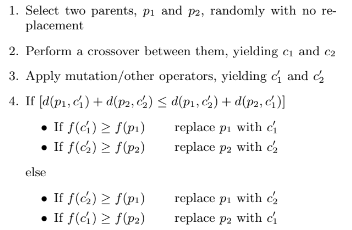

In [82]:
def crowding(population, fitness, replacements, child_fitness):
  """
  Implements deterministic crowding post reproduction.

  Note: this requires random selection to be done N/2 times
  """

  new_replacements = {}
  new_child_fitness = {}

  # Consider parent1 here the replacing parent, e.g. p1 for c1, or p2 for c2

  for p1, p2 in replacements.keys():
    # Grab genotypes
    p1_ge = population[p1]
    p2_ge = population[p2]
    c1_ge = replacements[(p1, p2)][0]
    c2_ge = replacements[(p1, p2)][1]

    # Grab fitness values
    p1_fit = fitness[p1]
    p2_fit = fitness[p2]
    c1_fit = child_fitness[(p1, p2)][0]
    c2_fit = child_fitness[(p1, p2)][1]

    # Initially, add in new replacements to the original parent values.
    # Nothing will change if both children are worse than the parents
    new_replacements[(p1, p2)] = [p1_ge, p2_ge]
    new_child_fitness[(p1, p2)] = [p1_fit, p2_fit]

    if (ham_dist(p1_ge, c1_ge) + ham_dist(p2_ge, c2_ge)) <= (ham_dist(p1_ge, c2_ge) + ham_dist(p2_ge, c1_ge)):
      # Case where p1 closer to c1, p2 closer to c2
      if c1_fit > p1_fit:
        new_replacements[(p1, p2)][0] = c1_ge
        new_child_fitness[(p1, p2)][0] = c1_fit

      if c2_fit > p2_fit:
        new_replacements[(p1, p2)][1] = c2_ge
        new_child_fitness[(p1, p2)][1] = c2_fit

    else:
      # Case where p2 closer to c1, p1 closer to c2
      if c1_fit > p2_fit:
        new_replacements[(p1, p2)][1] = c1_ge
        new_child_fitness[(p1, p2)][1] = c1_fit

      if c2_fit > p1_fit:
        new_replacements[(p1, p2)][0] = c2_ge
        new_child_fitness[(p1, p2)][0] = c2_fit


  return new_replacements, new_child_fitness


crowding(pop, fitness, replacements, child_fitness)


({(np.int64(26), np.int64(14)): [array([0, 0, 0, 1, 1, 0, 0, 1, 1, 0]),
   array([1, 1, 0, 0, 0, 0, 1, 1, 0, 1])],
  (np.int64(2), np.int64(6)): [array([0, 1, 0, 0, 0, 1, 0, 1, 1, 0]),
   array([1, 0, 0, 1, 0, 0, 0, 0, 0, 0])],
  (np.int64(13), np.int64(27)): [array([1, 0, 0, 0, 0, 1, 0, 1, 1, 0]),
   array([1, 0, 0, 1, 0, 0, 1, 1, 1, 1])],
  (np.int64(0), np.int64(25)): [array([1, 1, 0, 1, 0, 0, 1, 0, 1, 1]),
   array([0, 1, 1, 1, 1, 0, 0, 0, 1, 1])],
  (np.int64(24), np.int64(5)): [array([1, 1, 1, 0, 0, 1, 1, 0, 0, 1]),
   array([0, 1, 0, 1, 1, 0, 0, 0, 0, 1])],
  (np.int64(20), np.int64(18)): [array([0, 0, 1, 1, 1, 1, 0, 0, 1, 0]),
   array([0, 1, 0, 0, 1, 0, 0, 0, 1, 1])],
  (np.int64(3), np.int64(22)): [array([1, 1, 0, 0, 0, 1, 1, 0, 0, 1]),
   array([1, 1, 0, 0, 0, 0, 0, 0, 1, 1])],
  (np.int64(8), np.int64(29)): [array([1, 0, 0, 0, 1, 0, 0, 0, 0, 1]),
   array([1, 1, 1, 0, 0, 0, 0, 0, 0, 0])],
  (np.int64(11), np.int64(15)): [array([0, 0, 1, 0, 0, 1, 0, 1, 1, 0]),
   array([0, 0

In [83]:
child_fitness

{(np.int64(26), np.int64(14)): (np.float64(0.999887057011023),
  np.float64(0.028604180129460987)),
 (np.int64(2), np.int64(6)): (np.float64(0.5362378254843941),
  np.float64(0.02940585499736424)),
 (np.int64(13), np.int64(27)): (np.float64(0.705845300968254),
  np.float64(0.0018793824476617327)),
 (np.int64(0), np.int64(25)): (np.float64(0.002071263132408507),
  np.float64(0.5409830188539324)),
 (np.int64(24), np.int64(5)): (np.float64(0.9918689939468942),
  np.float64(0.19760167578134682)),
 (np.int64(20), np.int64(18)): (np.float64(0.02484218938213585),
  np.float64(0.8292754926541619)),
 (np.int64(3), np.int64(22)): (np.float64(0.003582579201515719),
  np.float64(0.019036676500425828)),
 (np.int64(8), np.int64(29)): (np.float64(0.4475247615102819),
  np.float64(0.6218592167691132)),
 (np.int64(11), np.int64(15)): (np.float64(0.17105656365671298),
  np.float64(0.9512781199252771)),
 (np.int64(28), np.int64(1)): (np.float64(0.318341265312222),
  np.float64(1.3956381891755193e-08)),
 

### Sharing
![alt text](alg_sharing.png)


In [ ]:
def SH(d, sigma, alpha):
    if d < sigma:
        return 1 - ((d/sigma) ** alpha)

    return 0

def sharing(sigma, alpha, P, fitness_fun):
    """
    Computes sharing niching method 
    """

    #if the length of P is 1, then SH(d) = 1, so f'(i) = f(i)
    if len(P) == 1 :
        return np.array([fitness_fun(constrained_bin_float(P[0]))])


    ret = []

    for p in P:

        p_dist = constrained_bin_float(p)
        D = 0

        for other in P:
            other_dist = constrained_bin_float(other)

            if p_dist == other_dist:
                continue
            
            D += SH(abs(p_dist - other_dist), sigma, alpha)

        ret.append(min(1, fitness_fun(p_dist) / (D + 0.00001)))

            
    return np.array(ret)

fitness = sharing(0.1, 1, pop, M1)
fitness


array([5.84610656e-04, 4.13282034e-09, 1.36460370e-01, 2.50137751e-05,
       8.05025520e-04, 6.72248675e-02, 4.86064452e-03, 1.67698167e-06,
       1.15489963e-01, 1.60351078e-01, 1.00000000e+00, 9.12296807e-02,
       9.49812303e-02, 1.92845148e-01, 9.92900976e-03, 4.39577750e-01,
       2.87179387e-01, 1.75320488e-01, 2.46137850e-01, 8.21523726e-02,
       9.80659272e-03, 3.90785964e-05, 3.48548995e-02, 2.14877163e-01,
       4.49006666e-01, 2.30434381e-01, 4.45940671e-01, 2.46263352e-06,
       1.51618560e-01, 2.11977919e-01])

### Stochastic Crowding
![alt text](alg_crowding.png)

In [85]:
def stochastic_crowding(P, fitness_func, replacements, child_fitness, crowding_factor):

    if crowding_factor > len(P):
        raise Exception('Crowding factor must be smaller or equal to the total population')
    

    for parent1, parent2 in replacements:

         # sample indices of candidates that will compete with the children
        S = np.random.choice(len(P), size = crowding_factor, replace=False)

        (child1, child2) = replacements[(parent1, parent2)]
        (child1_fitness, child2_fitness) = child_fitness[(parent1, parent2)]

        for c, c_fitness in zip([child1, child2], [child1_fitness, child2_fitness]):
            # find most similar individual in S
            x_prime_index, _ = sorted([(s, ham_dist(c, P[s])) for s in S], key=lambda x : x[1])[0]

            if c_fitness > fitness_func(constrained_bin_float(P[x_prime_index])):
                P[x_prime_index] = c



## Plotting

In [86]:
import os

# create output directory
path = "graphs"
if not os.path.isdir(path):
    os.makedirs(path)

In [87]:
def plot_history(fitness_stats, title, arg):
  fig, ax = plt.subplots(1, figsize=(10,7))

  num_gen = np.arange(len(fitness_stats["min"]))
  ax.plot(num_gen, fitness_stats["min"], label="Min")
  ax.plot(num_gen, fitness_stats["max"], label="Max")
  ax.plot(num_gen, fitness_stats["mean"], label="Mean")

  plt.legend()
  ax.set_xlabel("Generation", fontweight="bold")
  ax.set_ylabel("Fitness", fontweight="bold")
  ax.grid(axis="y")
  plt.title(title, fontweight="bold", fontsize=14)

  func_name = "M1" if arg["cost_func"] == M1 else "M2"
  plt.savefig("graphs\\hist_{}_pc{}_pm{}_{}.png".format(func_name, arg["Pc"], arg["Pm"], arg["niching"]))

  plt.show()

  return

In [88]:
def plot_population(pop_history, title, arg):
  valid_initial = pop_history["initial"][(pop_history["initial"] > 0) & (pop_history["initial"] < 1)]
  valid_final = pop_history["final"][(pop_history["final"] > 0) & (pop_history["final"] < 1)]

  fig, ax = plt.subplots(1, figsize=(10,7))

  # Plot function landscape
  ax.plot(
      np.arange(0, 1, 0.001), [arg["cost_func"](x) for x in np.arange(0, 1, 0.001)], color="grey", zorder=1
      )

  # Plot initial population
  ax.scatter(valid_initial, list(map(arg["cost_func"], valid_initial)), color="red", zorder=3, label="Initial")

  # Plot final
  ax.scatter(valid_final, list(map(arg["cost_func"], valid_final)), color="blue", zorder=4, label="Final")

  # Figure characteristics
  plt.title(title, fontweight="bold", fontsize=14)
  plt.xlabel("Phenotype Value", fontweight="bold")
  plt.ylabel("Fitness", fontweight="bold")
  plt.legend()

  func_name = "M1" if arg["cost_func"] == M1 else "M2"
  plt.savefig("graphs\\pop_{}_pc{}_pm{}_{}.png".format(func_name, arg["Pc"], arg["Pm"], arg["niching"]))

  plt.show()
  return

## Algorithm

In [89]:
def genetic_algorithm(cost_func,
                      cross_method,
                      niching,
                      num_gen,
                      pop_size,
                      num_mating,
                      Pc, Pm,
                      rand_gen=None,
                      **kwargs):

  population = initialize_pop(pop_size, rand_gen=rand_gen)

  # compute fitness values for all population
  if niching == "sharing":
    fitness = sharing(kwargs["sigma"], kwargs["alpha"], population, cost_func)
  else:
    fitness = compute_fitness(population, cost_func)

  # Bookkeeping
  fitness_stats = {"min":[], "max":[], "mean":[]}
  fitness_stats["min"].append(fitness.min())
  fitness_stats["max"].append(fitness.max())
  fitness_stats["mean"].append(fitness.mean())

  # Store the initial population, and final later
  pop_history = {"initial":copy.deepcopy(population)}
  pop_history["initial"] = np.array(list(map(constrained_bin_float, pop_history["initial"])))

  for gen in range(num_gen):
    if niching == "sharing":
      fitness = sharing(kwargs["sigma"], kwargs["alpha"], population, cost_func)
    else:
      fitness = compute_fitness(population, cost_func)

    if niching == "None":
      selected = roulette_selection(fitness, num_mating, rand_gen)
    elif niching == "crowding" or niching == "stochastic_crowding":
      selected = random_selection(fitness, num_mating=len(population), rand_gen=rand_gen)
    elif niching == "sharing":
      selected = roulette_selection(fitness, num_mating, rand_gen)

    # Perform crossover/mutation (only need parent_dict for niching)
    replacements, child_fitness = reproduce(
        population,
        selected,
        cross_method,
        cost_func,
        Pc,
        Pm,
        rand_gen
    )

    if niching == "crowding":
      # Idea here seems to be that we will replace only the parents based on distance
      replacements, child_fitness = crowding(population,
                                             fitness,
                                             replacements,
                                             child_fitness)
      
    if niching != "stochastic_crowding":
      for k in replacements.keys():
        # Replace p1 with c1
        population[k[0]] = replacements[k][0]
        fitness[k[0]] = child_fitness[k][0]

        # Replace p2 with c2
        population[k[1]] = replacements[k][1]
        fitness[k[1]] = child_fitness[k][1]
    else:
      # for stochastic crowding, we replace the population directly
      stochastic_crowding(population, cost_func, replacements, child_fitness, kwargs["crowding_factor"])

    # recalculate fitness so we have the most up to date values    
    if niching == "sharing":
      stats_fitness = sharing(kwargs["sigma"], kwargs["alpha"], population, cost_func)
    else:
      stats_fitness = compute_fitness(population, cost_func)
    stats_fitness = np.minimum(stats_fitness, 1) # prevent high fitness values whihc can result from sharing

    # Compute fitness metrics at the very end of each iteration
    fitness_stats["min"].append(stats_fitness.min())
    fitness_stats["max"].append(stats_fitness.max())
    fitness_stats["mean"].append(stats_fitness.mean())

  # Store the final population
  pop_history["final"] = np.array(list(map(constrained_bin_float, population)))


  return fitness_stats, fitness, pop_history

## Niching Evaluation

In [90]:
def count_peaks(pop_history, which_cost):

  M1_niche_points_copy = copy.deepcopy(M1_niche_points)
  M4_niche_points_copy = copy.deepcopy(M4_niche_points)

  total_peaks = 0
  for _, p in enumerate(pop_history["final"]):
    if which_cost == "M1":
      for i, j in enumerate(M1_niche_points_copy):
        if np.abs(p - j) < 1e-2:
          total_peaks += 1
          M1_niche_points_copy.pop(i)

    elif which_cost == "M4":
      for j in M4_niche_points_copy:
        if np.abs(p - j) < 1e-2:
          total_peaks += 1
          M4_niche_points_copy.remove(j)

  return total_peaks

# Experimentation
---

## GA Algorithm - Experiments

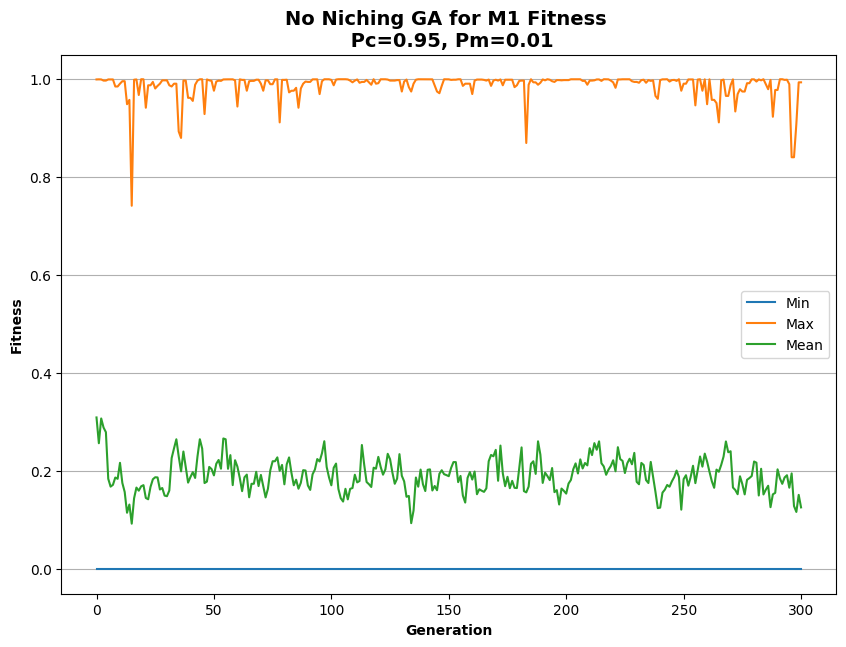

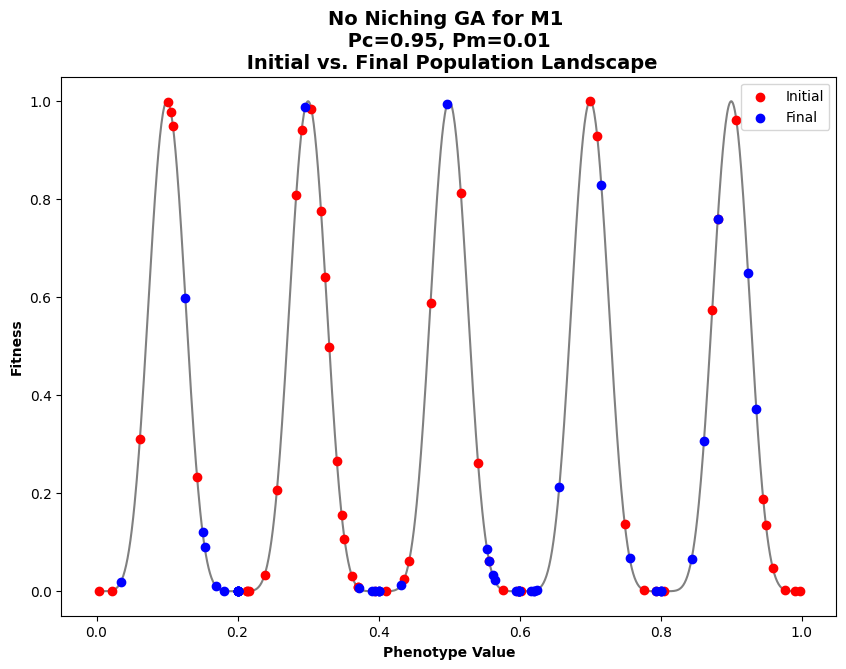

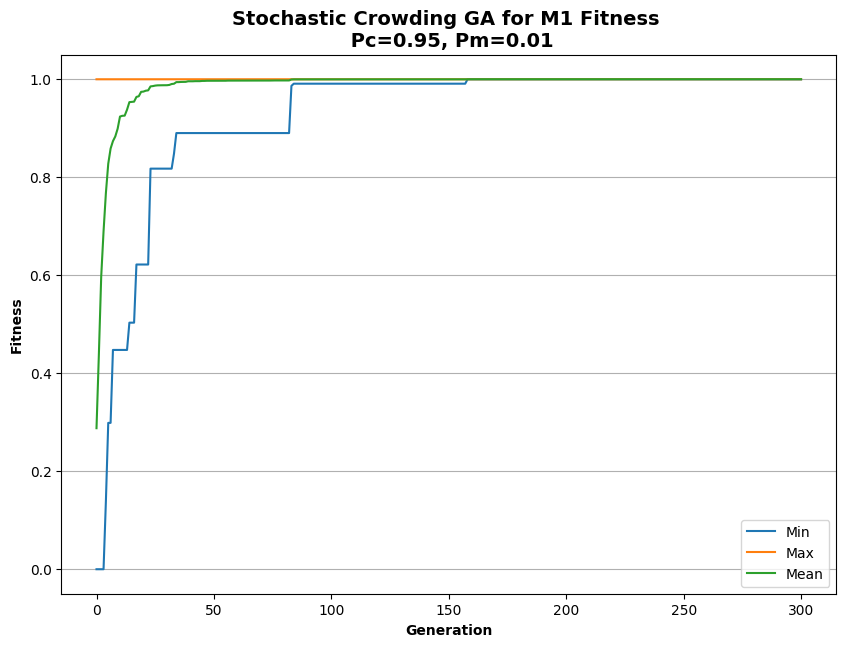

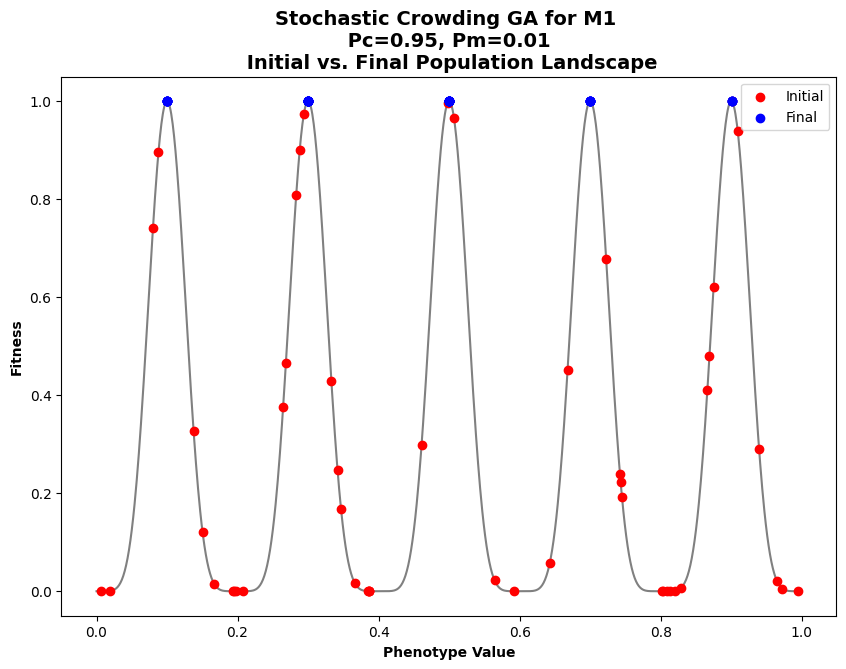

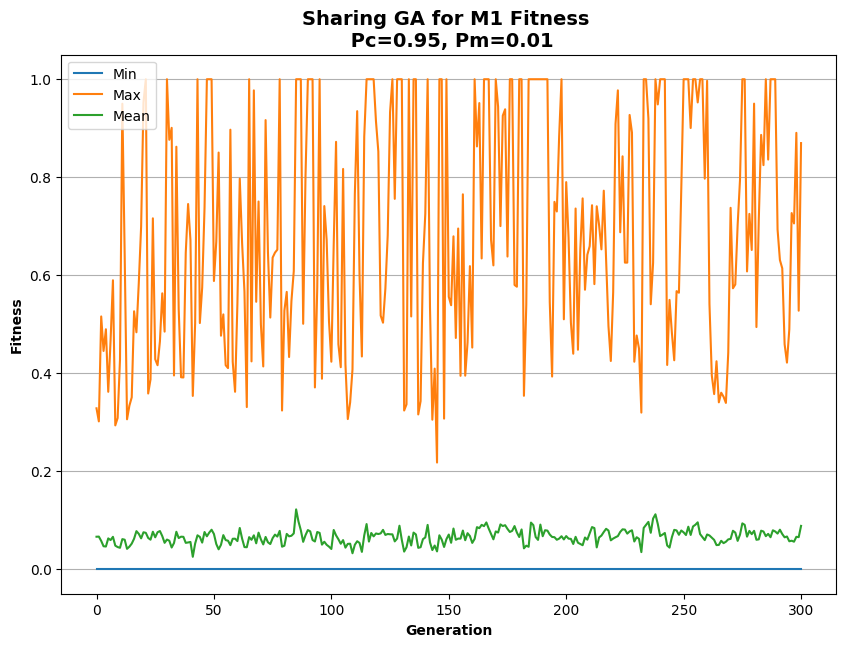

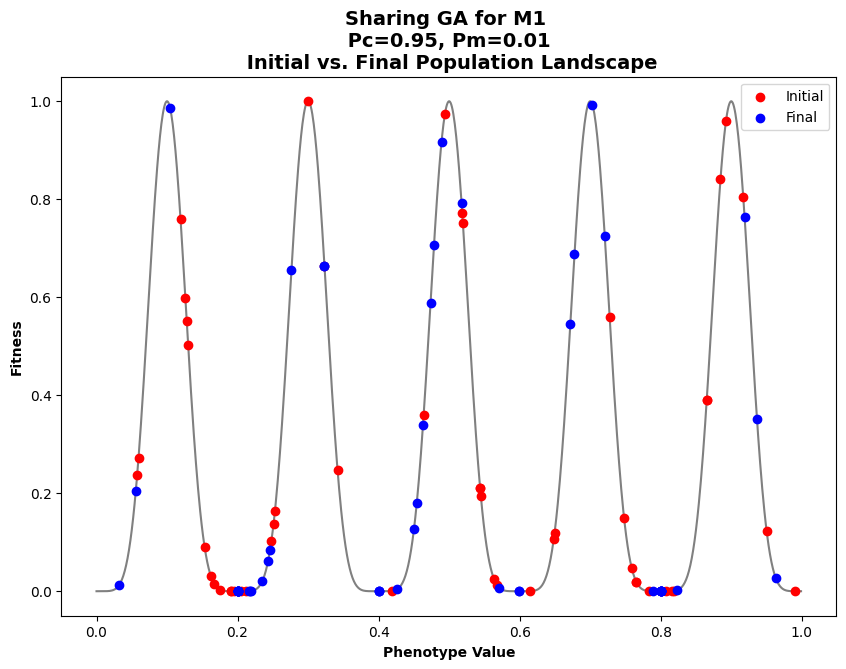

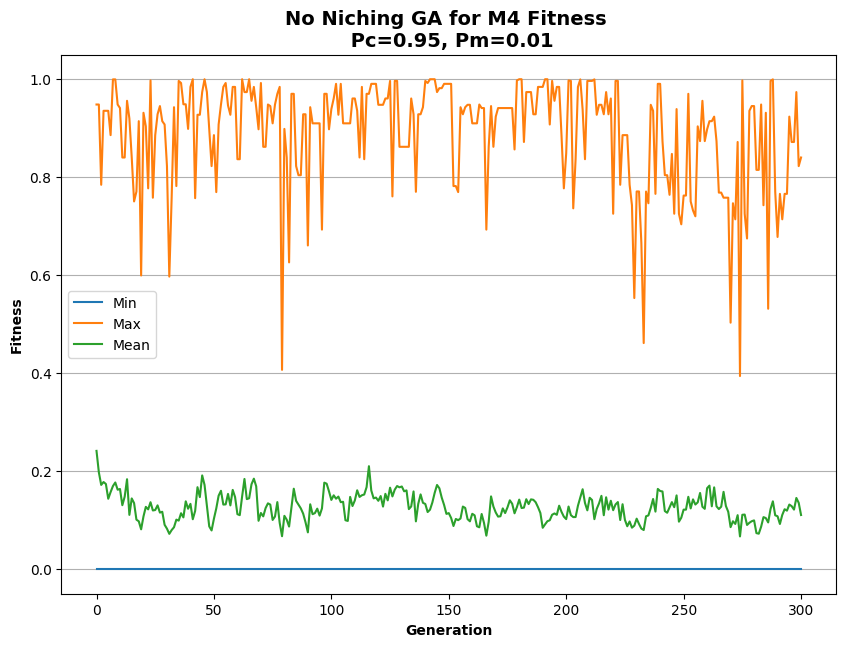

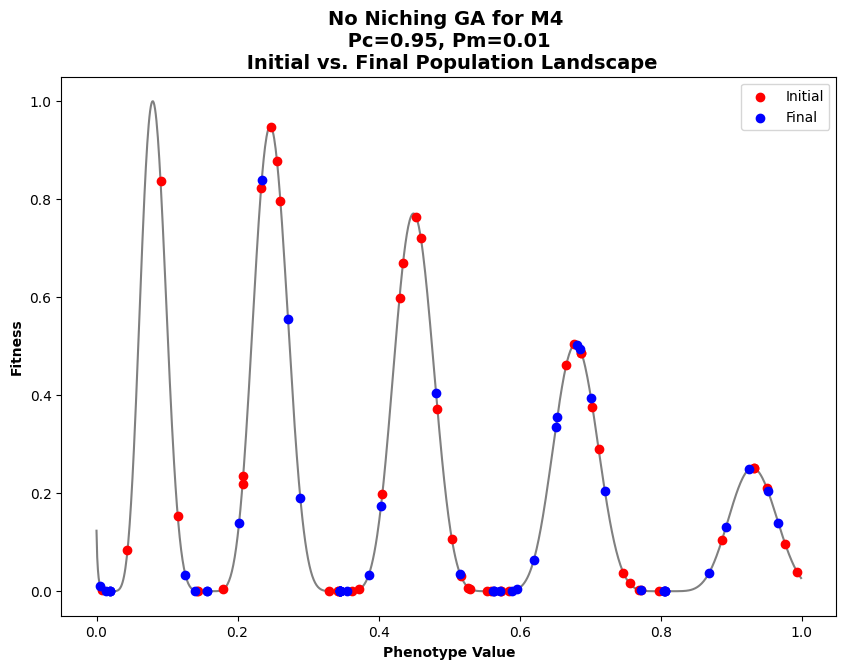

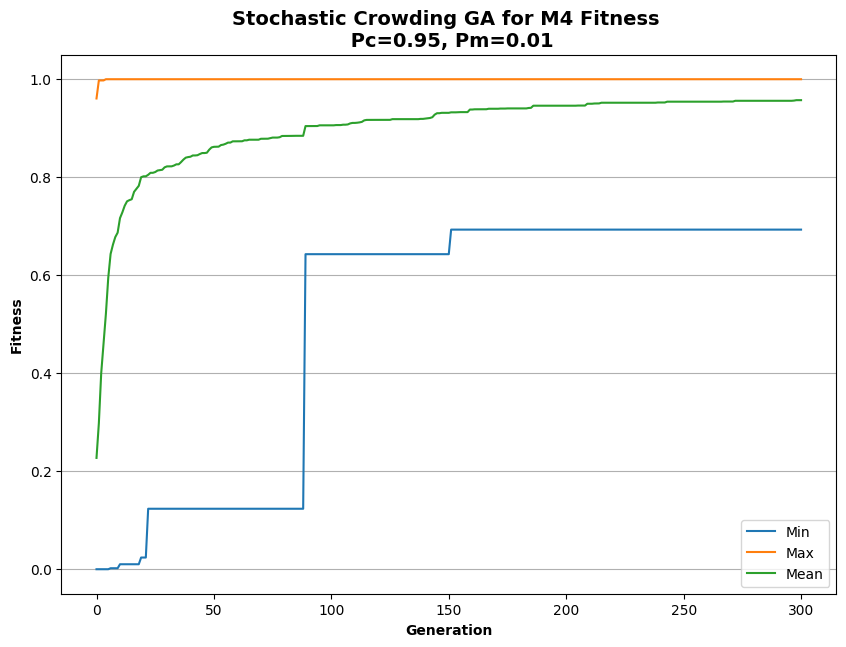

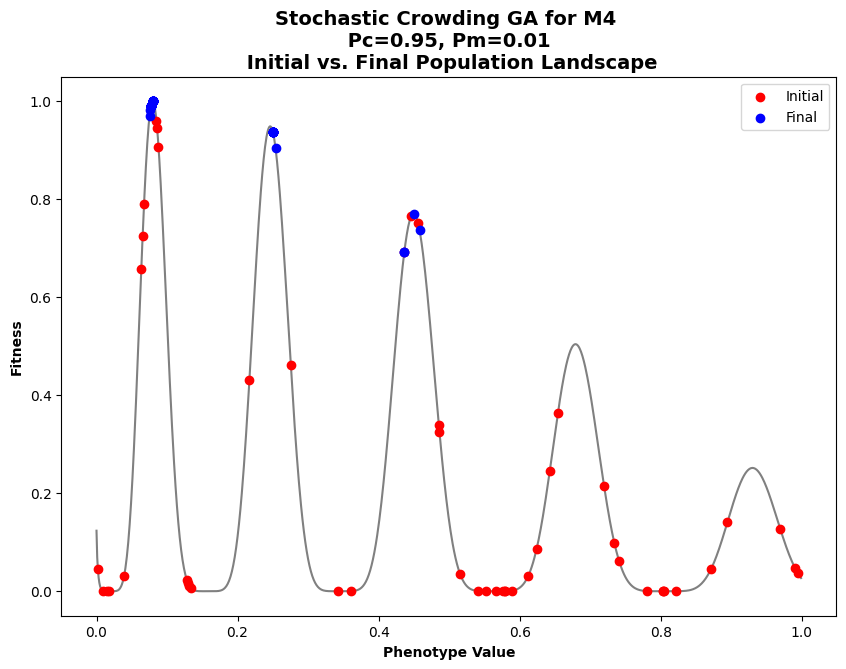

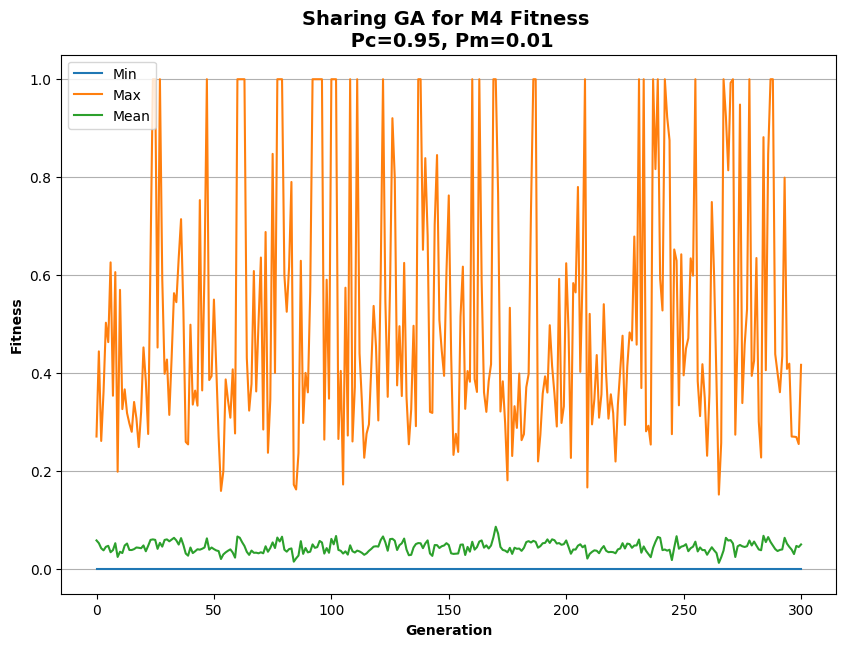

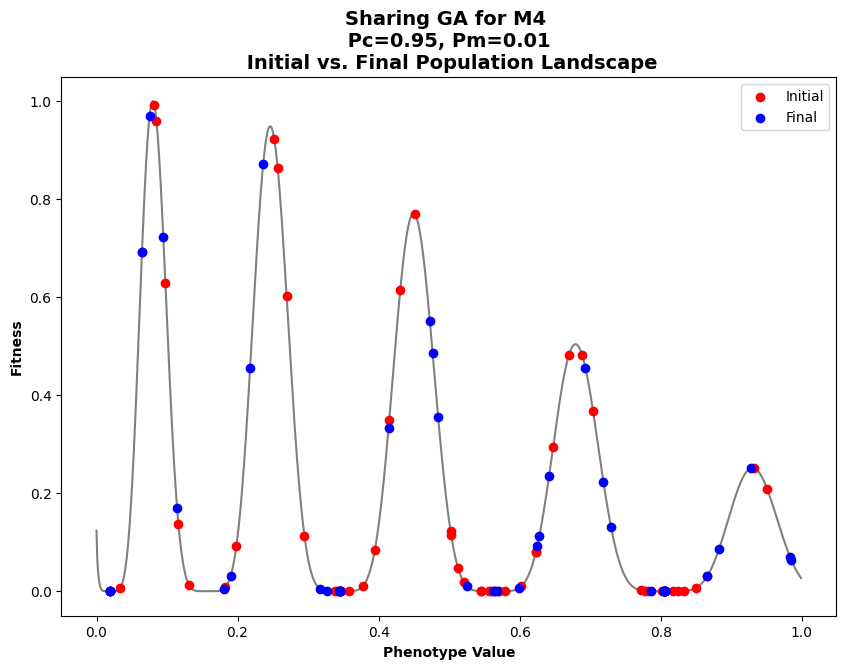

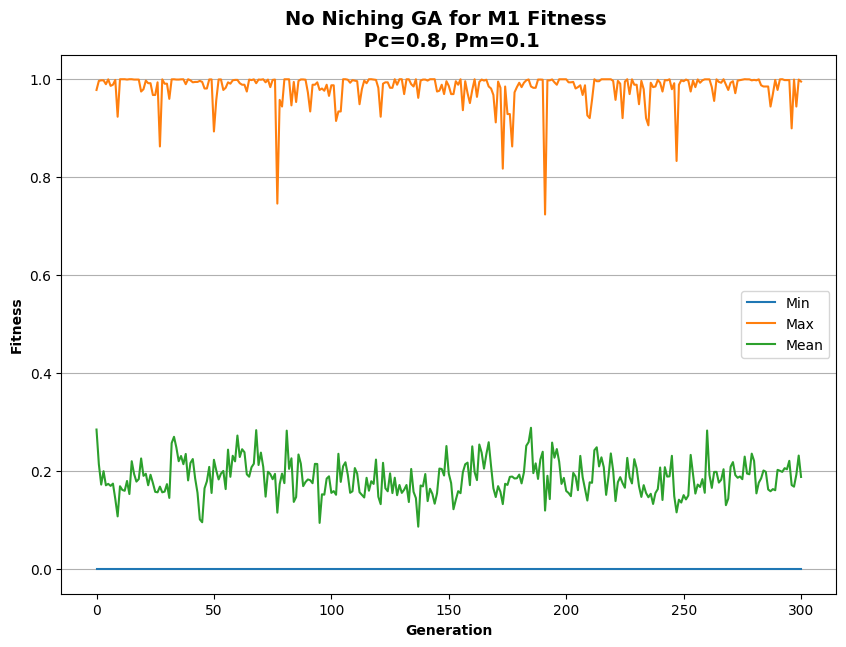

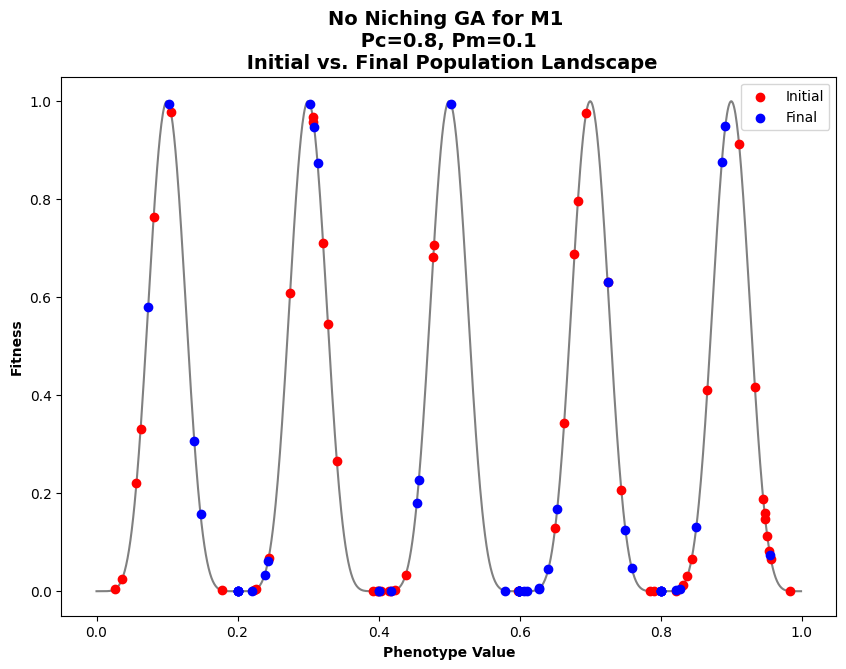

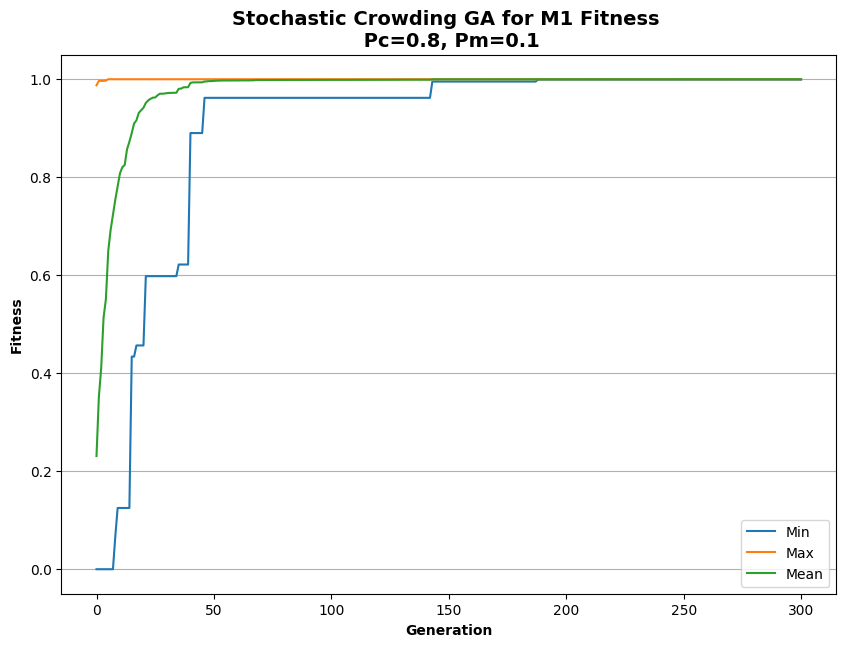

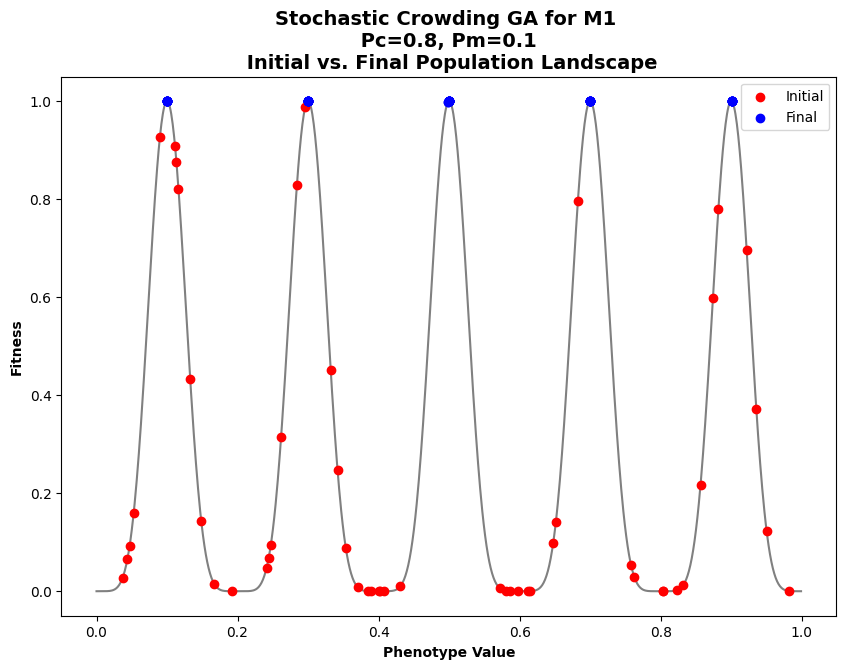

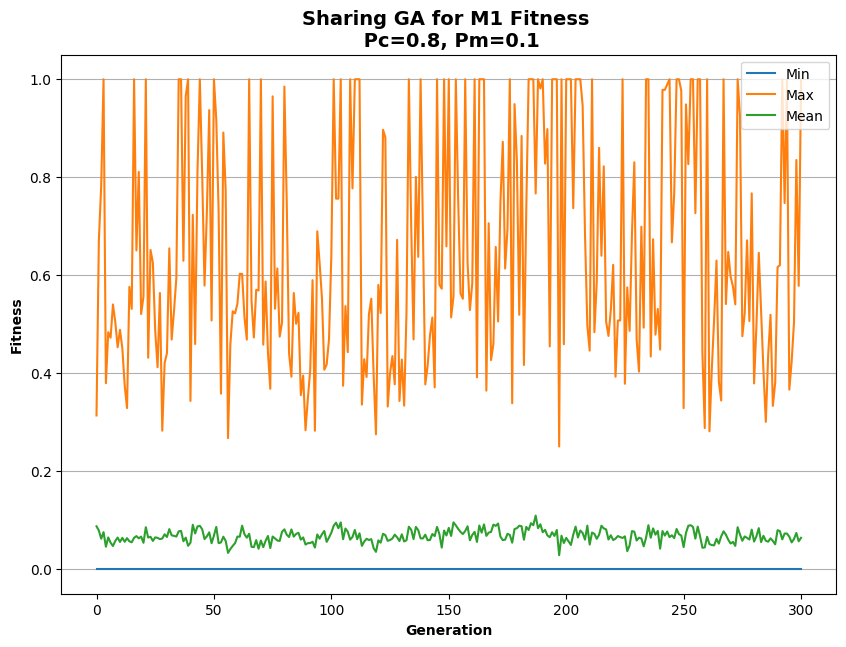

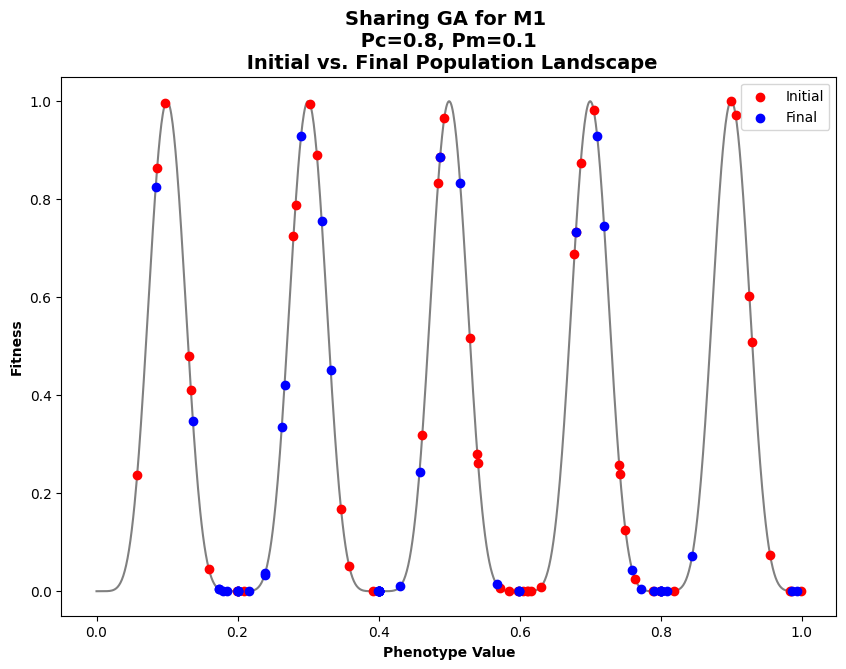

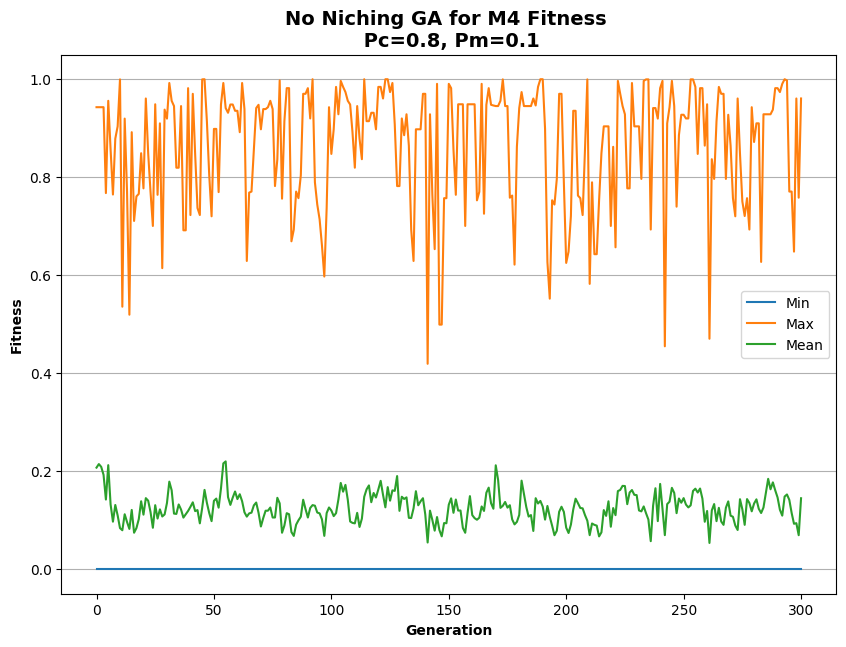

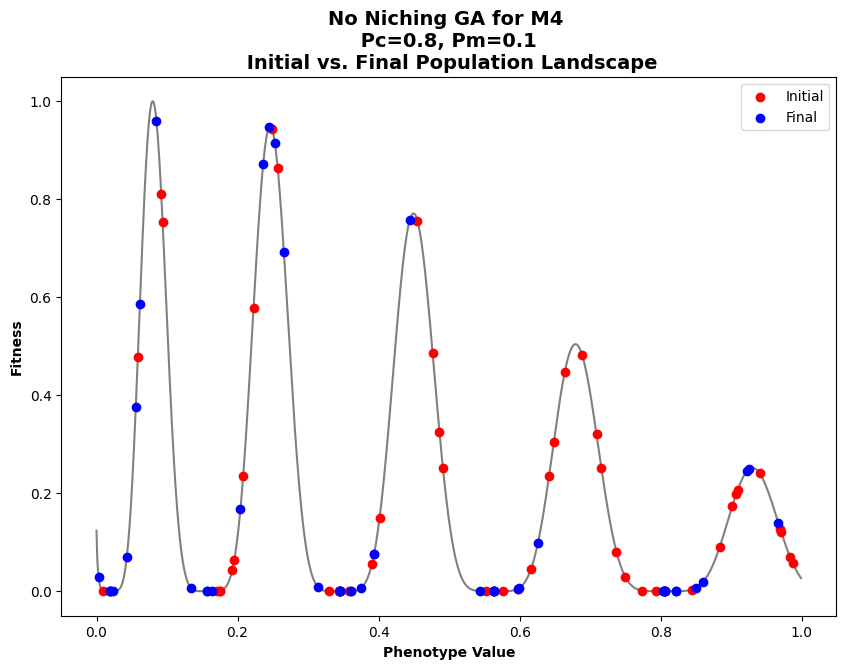

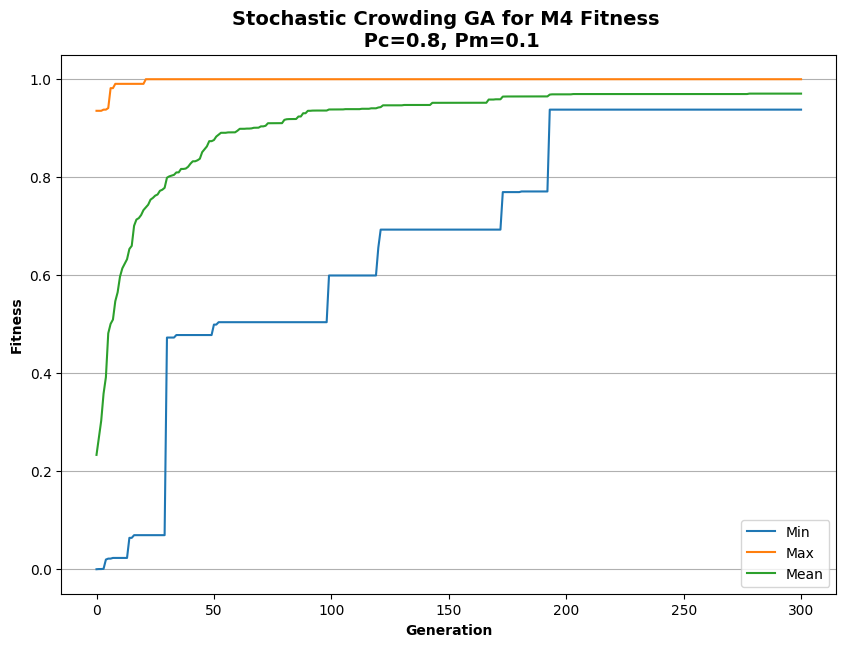

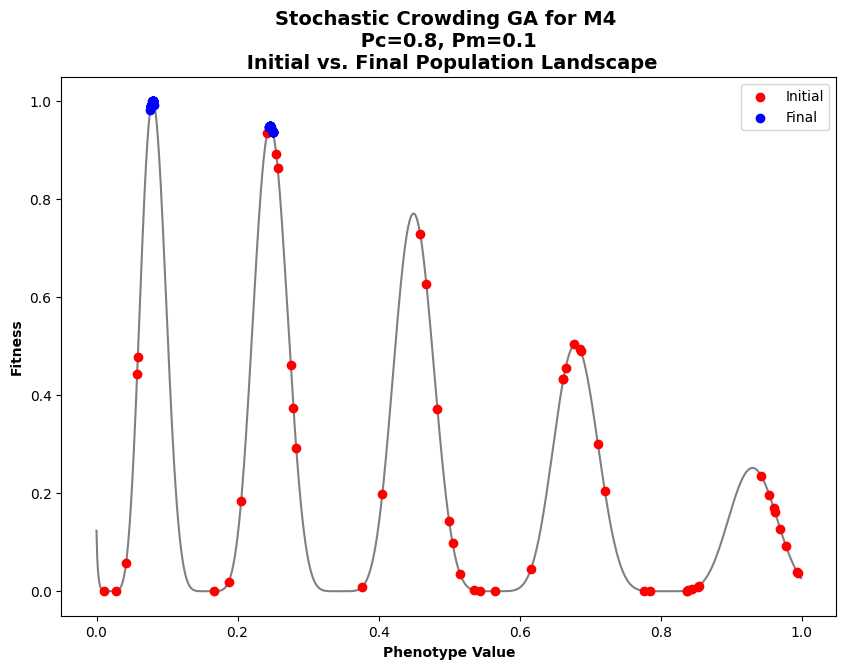

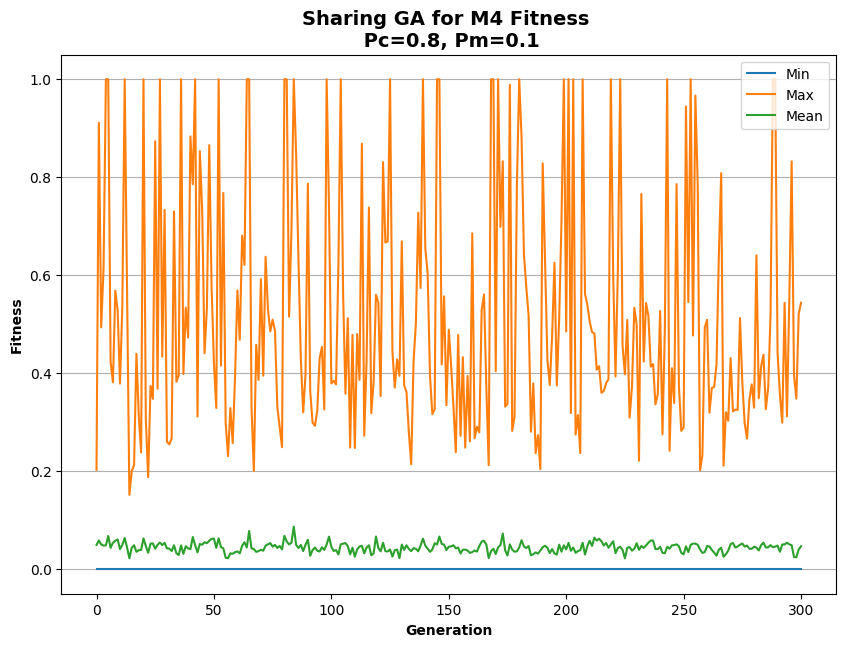

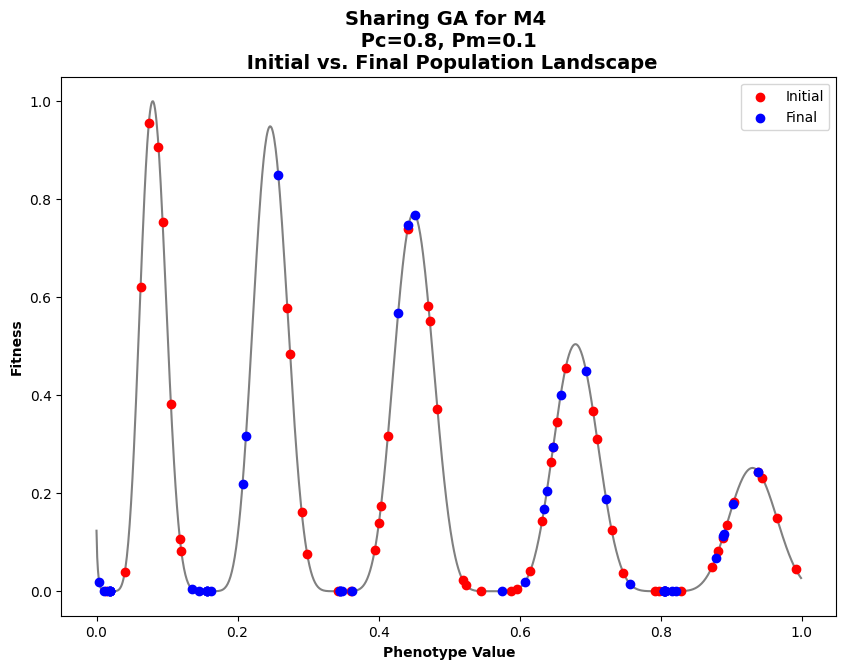

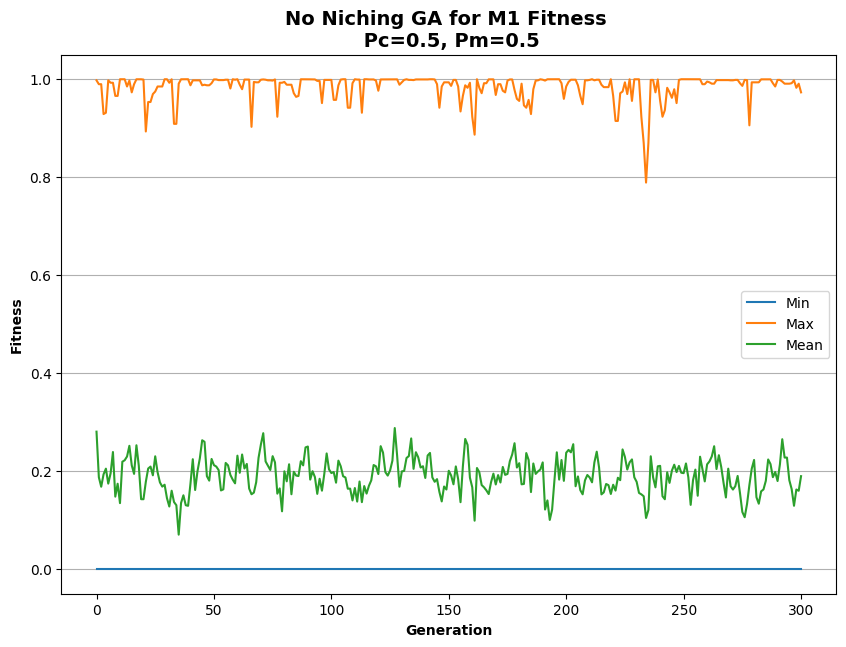

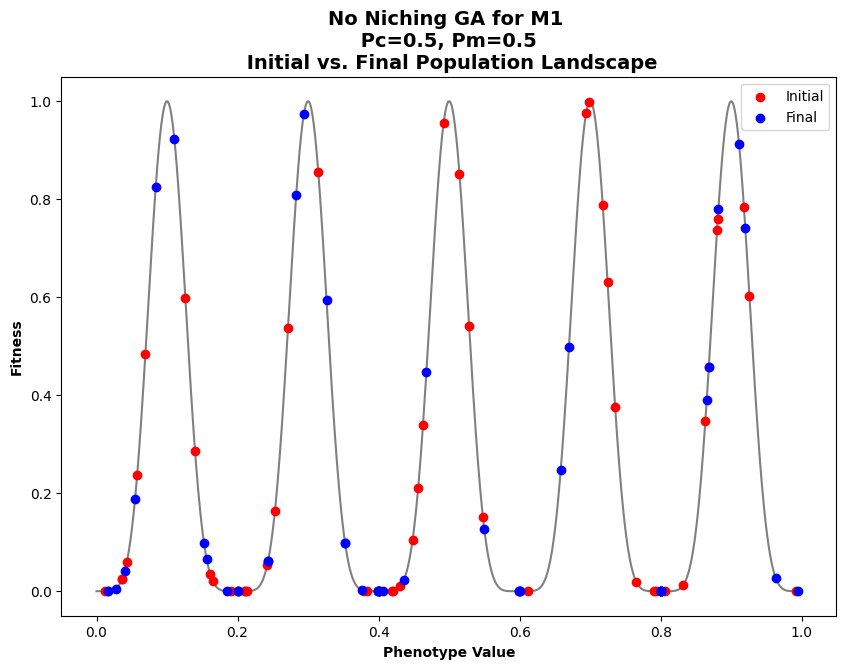

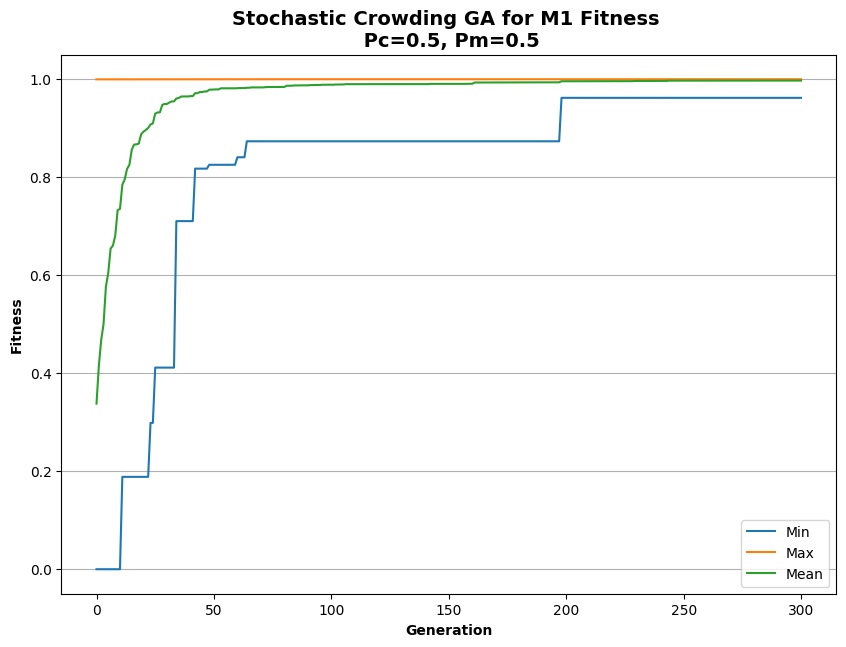

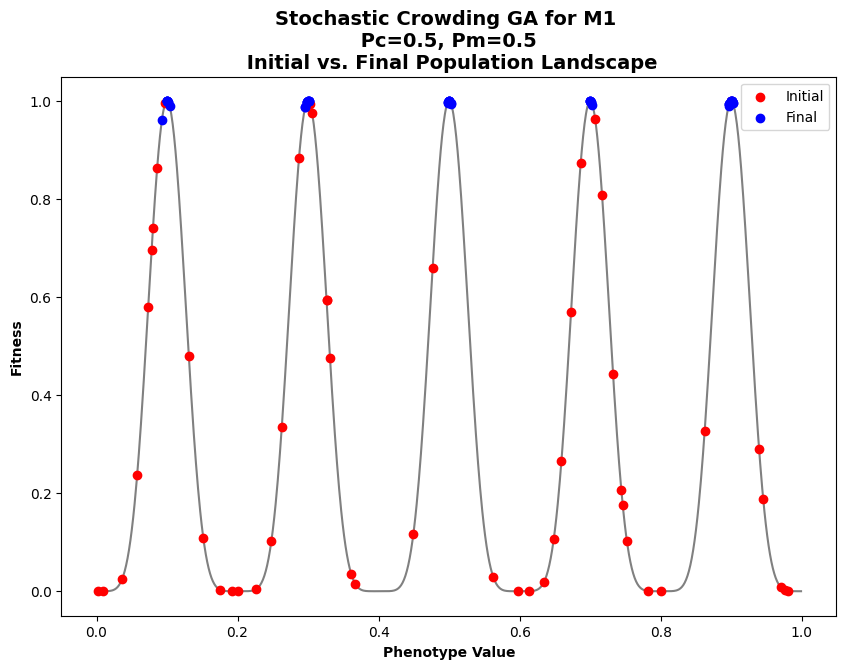

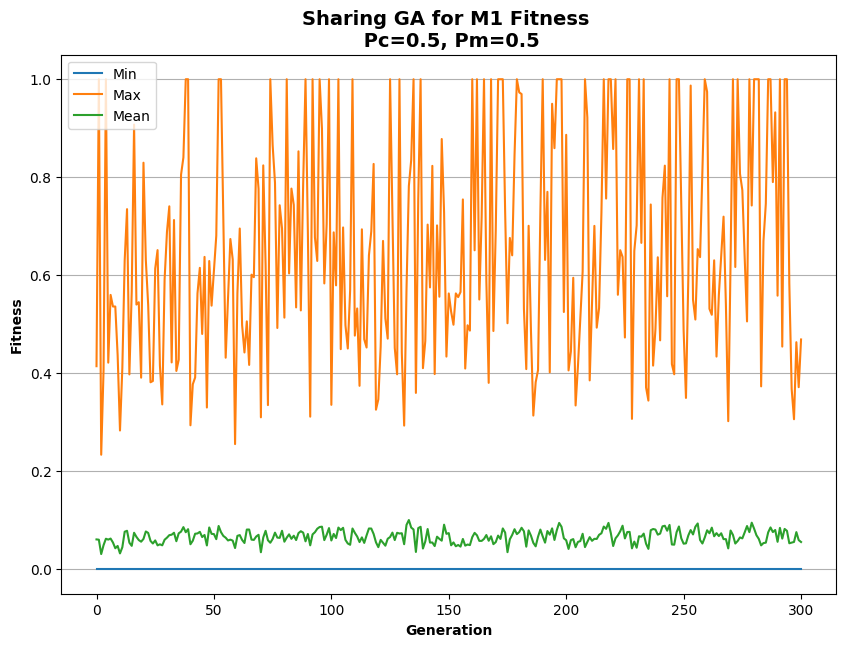

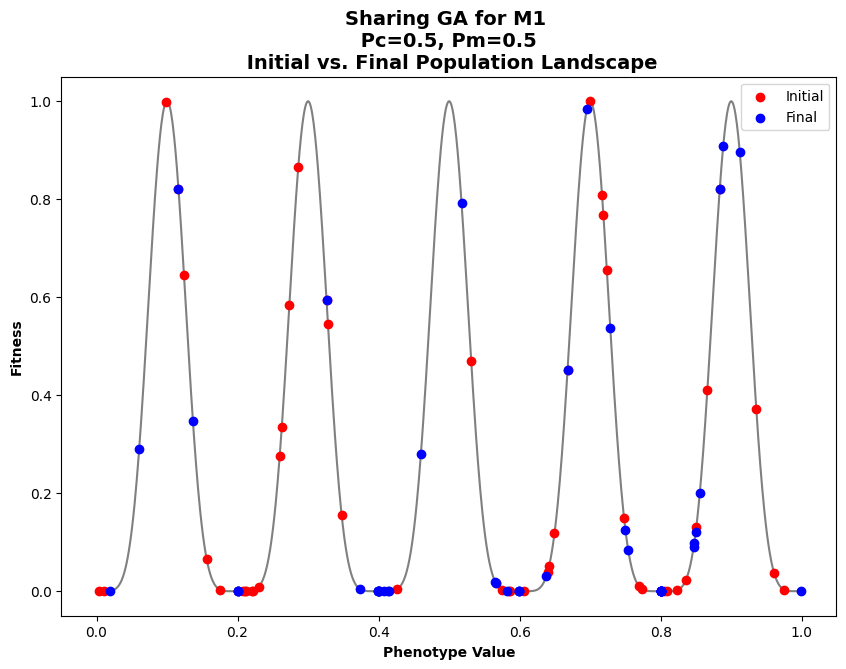

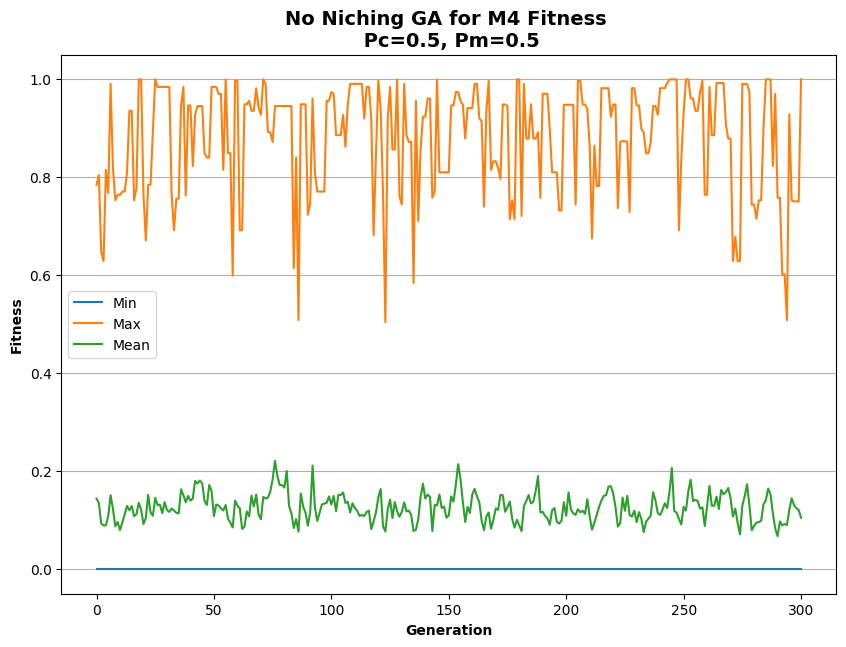

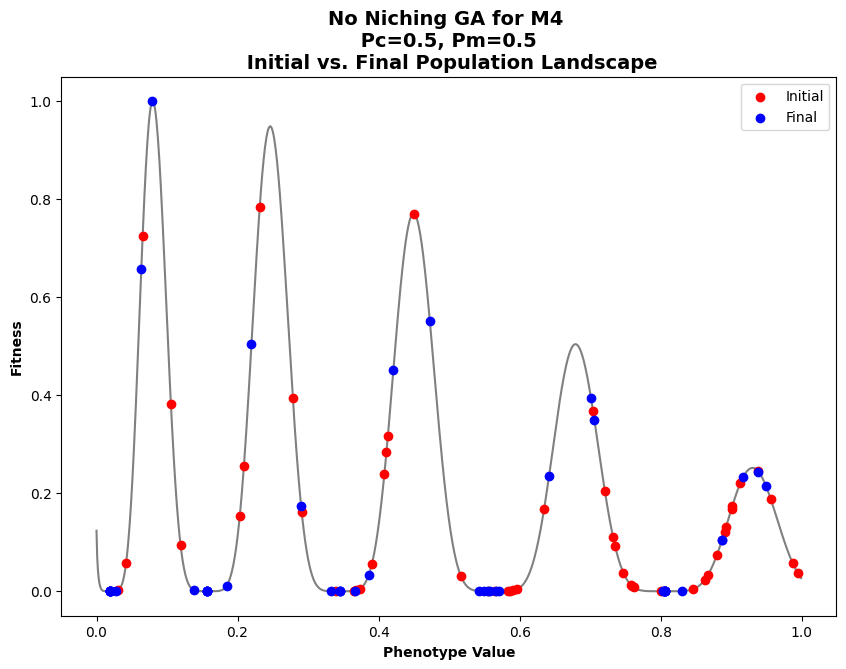

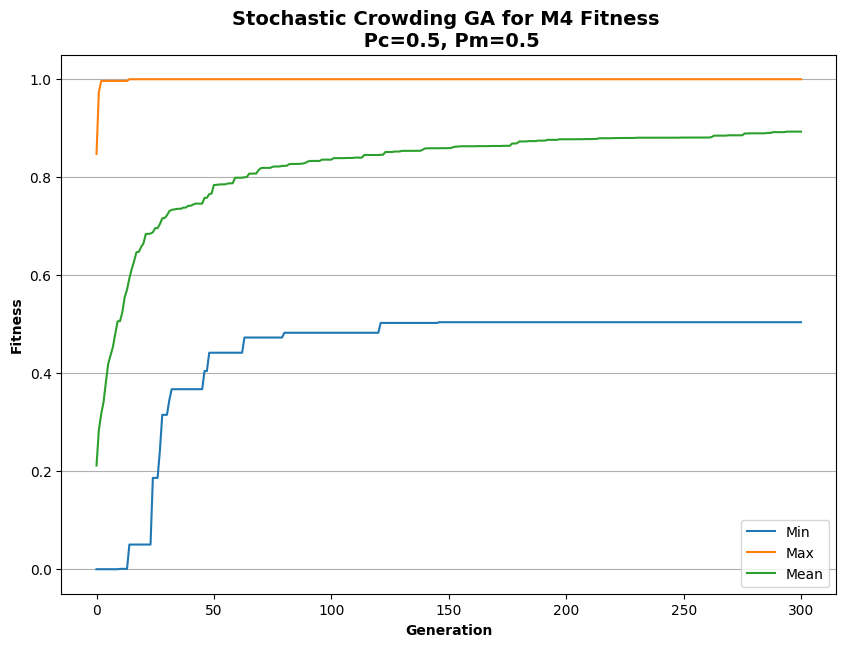

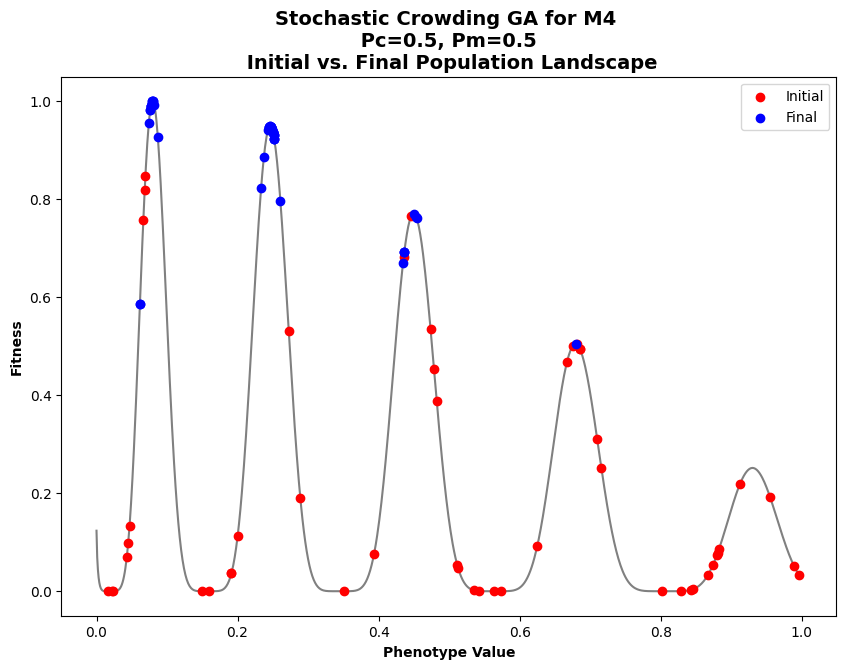

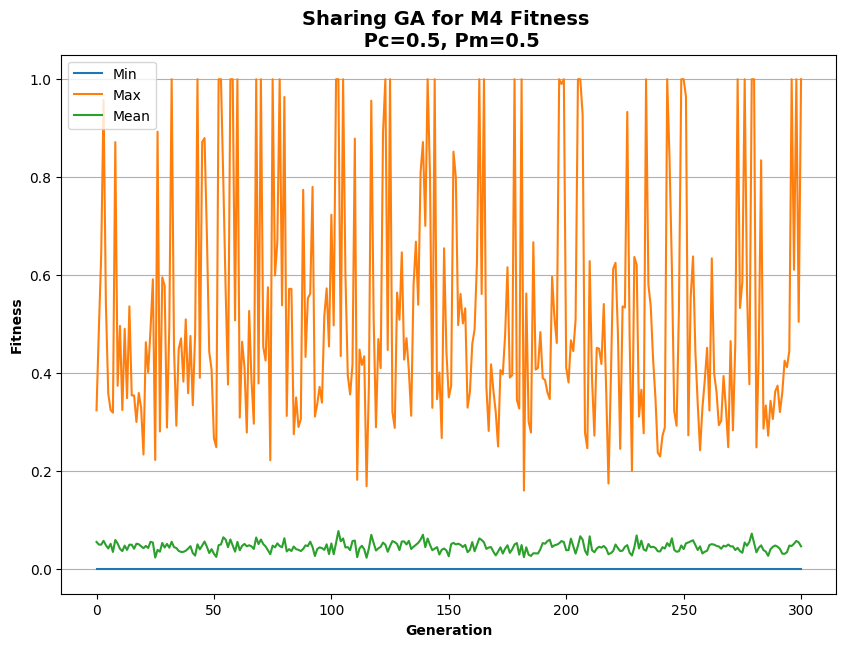

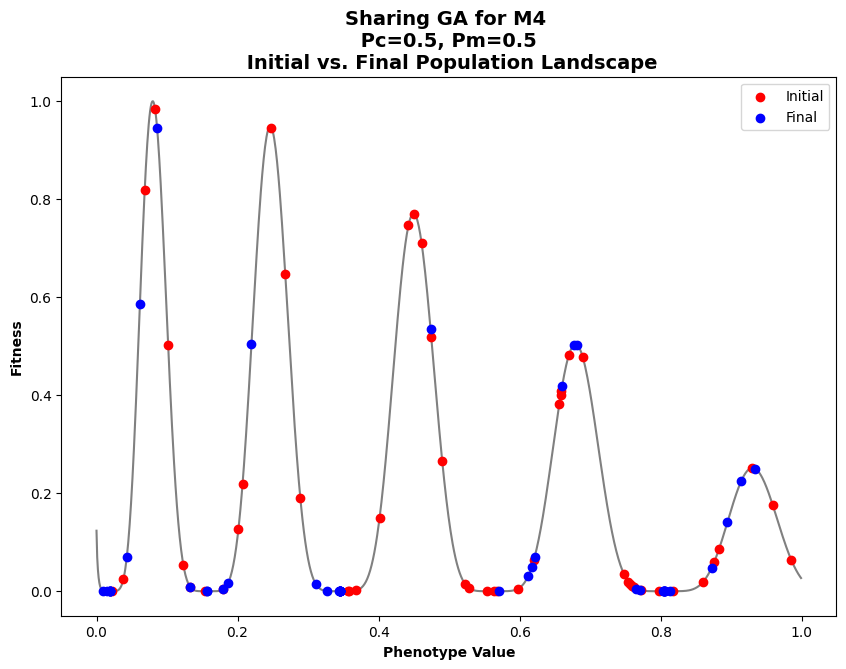

In [91]:
# %%script false

def run_experiments(function_name, title, repeat = 10, **kwargs):
    
    kwargs["rand_gen"] = np.random.default_rng()
    kwargs["cross_method"] = two_point_cross
    
    mins = []
    means = []
    maxs = []

    initials = []
    finals = []

    if function_name == "M1":
        kwargs["cost_func"] = M1
    
    if function_name == "M4":
        kwargs["cost_func"] = M4

    for _ in range(repeat):

        fitness_stats, _, pop_history = genetic_algorithm(**kwargs)

        mins.append(fitness_stats['min'])
        maxs.append(fitness_stats["max"])
        means.append(fitness_stats['mean'])

        initials.append(pop_history['initial'])
        finals.append(pop_history['final'])
            

    avg_fitness_stats = {}
    avg_fitness_stats['min'] = np.array(mins).mean(axis = 0)
    avg_fitness_stats['max'] = np.array(maxs).mean(axis = 0)
    avg_fitness_stats['mean'] = np.array(means).mean(axis = 0)

    avg_pop_history = {}
    avg_pop_history['initial'] = np.array(initials).mean(axis = 0)
    avg_pop_history['final'] = np.array(finals).mean(axis = 0)

    hist_title = f"{title} for {function_name} Fitness \n Pc={kwargs['Pc']}, Pm={kwargs['Pm']}"
    plot_history(fitness_stats, hist_title, kwargs)

    plot_title = f"{title} for {function_name} \n Pc={kwargs['Pc']}, Pm={kwargs['Pm']} \n Initial vs. Final Population Landscape"
    plot_population(pop_history, plot_title, kwargs)
    
for pc, pm in zip([0.95, 0.80, 0.50],[0.01, 0.1, 0.5]):
    run_experiments("M1", 
                "No Niching GA",
                repeat=10, 
                Pc = pc, 
                Pm = pm, 
                num_gen = 300, 
                pop_size = 50, 
                num_mating = 30,
                crowding_factor = 15,
                niching = "None")

    run_experiments("M1", 
                "Stochastic Crowding GA",
                repeat=10, 
                Pc = pc, 
                Pm = pm, 
                num_gen = 300, 
                pop_size = 50, 
                num_mating = 30,
                crowding_factor = 15,
                niching = "stochastic_crowding")

    run_experiments("M1", 
                "Sharing GA",
                repeat=10, 
                Pc = pc, 
                Pm = pm, 
                num_gen = 300, 
                pop_size = 50, 
                num_mating = 30,
                sigma = 0.1,
                alpha = 1,
                niching = "sharing")
    
    run_experiments("M4", 
                "No Niching GA",
                repeat=10, 
                Pc = pc, 
                Pm = pm, 
                num_gen = 300, 
                pop_size = 50, 
                num_mating = 30,
                crowding_factor = 15,
                niching = "None")

    run_experiments("M4", 
                "Stochastic Crowding GA",
                repeat=10, 
                Pc = pc, 
                Pm = pm, 
                num_gen = 300, 
                pop_size = 50, 
                num_mating = 30,
                crowding_factor = 15,
                niching = "stochastic_crowding")

    run_experiments("M4", 
                "Sharing GA",
                repeat=10, 
                Pc = pc, 
                Pm = pm, 
                num_gen = 300, 
                pop_size = 50, 
                num_mating = 30,
                sigma = 0.1,
                alpha = 1,
                niching = "sharing")
    
    


## M1 Loop

In [92]:
%%script false

arg = {
    "Pc": 0.95,
    "Pm": 0.01,
    "num_gen": 500,
    "pop_size": 50,
    "cost_func": M1,
    "cross_method": two_point_cross,
    "num_mating": 30,
    "niching": "None",
    "rand_gen": np.random.default_rng(15),
}

for Pc, Pm in zip([0.95, 0.80, 0.50],[0.01, 0.1, 0.5]):
  arg["Pc"] = Pc
  arg["Pm"] = Pm

  total_peaks = {"simple": 0, "crowding": 0, "sharing":0, "stochastic_crowding": 0}

  for seed in np.arange(1):
    arg["rand_gen"]: np.random.default_rng(seed)

    # Simple GA ----------------------------------------------------------------
    arg["niching"] = "None"
    fitness_stats, fitness, pop_history = genetic_algorithm(**arg)

    total_peaks["simple"] += count_peaks(pop_history, "M1")

    title = f"Simple GA for M1 Fitness \n Pc={arg['Pc']}, Pm={arg['Pm']}"
    plot_history(fitness_stats, title, arg)

    title = f"Simple GA for M1 \n Pc={arg['Pc']}, Pm={arg['Pm']} \n Initial vs. Final Population Landscape"
    plot_population(pop_history, title, arg)


    # Crowding -----------------------------------------------------------------
    arg["niching"] = "crowding"
    fitness_stats, fitness, pop_history = genetic_algorithm(**arg)

    total_peaks["crowding"] += count_peaks(pop_history, "M1")

    title = f"Crowding GA for M1 Fitness \n Pc={arg['Pc']}, Pm={arg['Pm']}"
    plot_history(fitness_stats, title, arg)

    title = f"Crowding GA for M1 \n Pc={arg['Pc']}, Pm={arg['Pm']} \n Initial vs. Final Population Landscape"
    plot_population(pop_history, title, arg)


    # sharing -----------------------------------------------------------------
    arg["niching"] = "sharing"
    arg["sigma"] = 0.1
    arg["alpha"] = 1
    fitness_stats, fitness, pop_history = genetic_algorithm(**arg)

    total_peaks["sharing"] += count_peaks(pop_history, "M1")

    title = f"Sharing GA for M1 Fitness \n Pc={arg['Pc']}, Pm={arg['Pm']}"
    plot_history(fitness_stats, title, arg)

    title = f"Sharing GA for M1 \n Pc={arg['Pc']}, Pm={arg['Pm']} \n Initial vs. Final Population Landscape"
    plot_population(pop_history, title, arg)


    # stochastic crowding -----------------------------------------------------------------
    arg["niching"] = "stochastic_crowding"
    arg["crowding_factor"] = 10
    fitness_stats, fitness, pop_history = genetic_algorithm(**arg)

    total_peaks["stochastic_crowding"] += count_peaks(pop_history, "M1")

    title = f"Stochastic Crowding GA for M1 Fitness \n Pc={arg['Pc']}, Pm={arg['Pm']}"
    plot_history(fitness_stats, title, arg)

    title = f"Stochastic Crowding GA for M1 \n Pc={arg['Pc']}, Pm={arg['Pm']} \n Initial vs. Final Population Landscape"
    plot_population(pop_history, title, arg)

  print(f"Pc = {Pc}, Pm = {Pm}")
  for k in total_peaks:
    print(k, total_peaks[k]/10)
  print("-"*30)

  break

Couldn't find program: 'false'


In [93]:
%%script false

arg = {
    "Pc": 0.95,
    "Pm": 0.01,
    "num_gen": 200,
    "pop_size": 50,
    "cost_func": M4,
    "cross_method": two_point_cross,
    "num_mating": 30,
    "niching": "None",
    "rand_gen": np.random.default_rng(15),
}

for Pc, Pm in zip([0.95, 0.80, 0.50],[0.01, 0.1, 0.5]):
  arg["Pc"] = Pc
  arg["Pm"] = Pm

  total_peaks = {"simple": 0, "crowding": 0, "sharing": 0, "stochastic_crowding": 0}

  for seed in np.arange(1):
    arg["rand_gen"]: np.random.default_rng(seed)

    # Simple GA ----------------------------------------------------------------
    arg["niching"] = "None"
    fitness_stats, fitness, pop_history = genetic_algorithm(**arg)

    total_peaks["simple"] += count_peaks(pop_history, "M4")

    title = f"Simple GA for M4 Fitness \n Pc={arg['Pc']}, Pm={arg['Pm']}"
    plot_history(fitness_stats, title, arg)

    title = f"Simple GA for M4 \n Pc={arg['Pc']}, Pm={arg['Pm']} \n Initial vs. Final Population Landscape"
    plot_population(pop_history, title, arg)


    # Crowding -----------------------------------------------------------------
    arg["niching"] = "crowding"
    fitness_stats, fitness, pop_history = genetic_algorithm(**arg)

    total_peaks["crowding"] += count_peaks(pop_history, "M4")

    title = f"Crowding GA for M4 Fitness \n Pc={arg['Pc']}, Pm={arg['Pm']}"
    plot_history(fitness_stats, title, arg)

    title = f"Crowding GA for M4 \n Pc={arg['Pc']}, Pm={arg['Pm']} \n Initial vs. Final Population Landscape"
    plot_population(pop_history, title, arg)


    # sharing -----------------------------------------------------------------
    arg["niching"] = "sharing"
    arg["sigma"] = 0.1
    arg["alpha"] = 1
    fitness_stats, fitness, pop_history = genetic_algorithm(**arg)

    total_peaks["sharing"] += count_peaks(pop_history, "M4")

    title = f"Sharing GA for M4 Fitness \n Pc={arg['Pc']}, Pm={arg['Pm']}"
    plot_history(fitness_stats, title, arg)

    title = f"Sharing GA for M4 \n Pc={arg['Pc']}, Pm={arg['Pm']} \n Initial vs. Final Population Landscape"
    plot_population(pop_history, title, arg)


    # stochastic crowding -----------------------------------------------------------------
    arg["niching"] = "stochastic_crowding"
    arg["crowding_factor"] = 10
    fitness_stats, fitness, pop_history = genetic_algorithm(**arg)

    total_peaks["stochastic_crowding"] += count_peaks(pop_history, "M4")

    title = f"Stochastic Crowding GA for M4 Fitness \n Pc={arg['Pc']}, Pm={arg['Pm']}"
    plot_history(fitness_stats, title, arg)

    title = f"Stochastic Crowding GA for M4 \n Pc={arg['Pc']}, Pm={arg['Pm']} \n Initial vs. Final Population Landscape"
    plot_population(pop_history, title, arg)

  print(f"Pc = {Pc}, Pm = {Pm}")
  for k in total_peaks:
    print(k, total_peaks[k]/10)
  print("-"*30)

  break

Couldn't find program: 'false'


## Crowding GA - Single

In [94]:
%%script false

arg = {
    "Pc": 0.95,
    "Pm": 0.003,
    "num_gen": 500,
    "pop_size": 50,
    "cost_func": M4,
    "cross_method": one_point_cross,
    "num_mating": 30,
    "niching": "crowding",
    "rand_gen": np.random.default_rng(15),
}

fitness_stats, fitness, pop_history = genetic_algorithm(**arg)

Couldn't find program: 'false'


In [95]:
%%script false

title = f"Crowding GA For M1 \n Pc={arg['Pc']}, Pm={arg['Pm']}"
plot_history(fitness_stats, title, arg)

Couldn't find program: 'false'


In [96]:
%%script false

title = f"Crowding GA Initial vs. Final Population Landscape \n Pc={arg['Pc']}, Pm={arg['Pm']}"
plot_population(pop_history, title, arg)

Couldn't find program: 'false'
